# Similarity Modeling 1/2: Recognizing Pigs with Deep Learning

## Student
Gallus Huber (51905700)

## Timesheet
2022-10-16 09:00 - 12:30 SIM 1 & 2 <br />
2022-10-16 15:00 - 17:00 SIM 3 <br />
2022-10-18 10:00 - 13:00 SIM 4 & 5 <br />
2022-10-27 20:00 - 22:00 SIM 6 <br />
2022-10-28 10:00 - 14:00 SIM 7 & 8 & 9 <br />
2022-11-02 08:00 - 14:00 Writing abstracts <br />
2022-11-10 14:00 - 15:00 Meeting <br />
2022-11-24 16:00 - 17:30 Setup <br />
2022-11-26 09:00 - 12:00 Implementation data preparation <br />
2022-11-27 10:00 - 10:30 Meeting <br />
2022-11-27 10:30 - 15:00 Implementation model <br />
2022-12-01 16:00 - 20:00 Training of model <br />
2022-12-03 14:00 - 18:00 Improvements <br />
2022-12-04 19:00 - 20:00 Meeting <br />
2022-12-18 14:00 - 18:00 Improvements & training <br />
2022-12-27 18:20 - 21:00 Improvements <br />
2022-12-31 15:00 - 16:00 Meeting <br />
2022-01-07 14:00 - 15:00 Finalize

## Required libraries and installs

In [5]:
!cat requirements-dl-video.txt
!pip install -r requirements-dl-video.txt

pandas
numpy
opencv-python
matplotlib
scikit-learn
scikit-image
tensorflow
keras
visualkeras
seabornLooking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 37.3 MB/s eta 0:00:00


## Imports

In [6]:
import os
import glob
import pathlib
import collections

import pandas as pd
import numpy as np

import cv2 as cv2
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.model_selection as ms
import sklearn.metrics as mt

import tensorflow as tf

import keras.applications as appl
import keras.models as models
import keras.layers as layers
import keras.utils as utils
import keras.callbacks as cb
import keras.optimizers as optimizers

import visualkeras

## Constants

In [7]:
# path to ground truth and videos
DATA_PATH = "../data/"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "sim12-ground-truth-muppets")
VIDEO_PATH = os.path.join(DATA_PATH, "video")

# path to train data
TRAINING_PATH = os.path.join(".", 'training_data')
VALIDATION_PATH = os.path.join(".", 'validation_data')
TESTING_PATH = os.path.join(".", 'testing_data')

# path to save and load trained models
MODEL_PATH = "../models/video"

# Project Structure

In [8]:
# create dirs for training
train_path_0 = os.path.join(TRAINING_PATH, '0')
train_path_1 = os.path.join(TRAINING_PATH, '1')

# create dirs for validation
valid_path_0 = os.path.join(VALIDATION_PATH, '0')
valid_path_1 = os.path.join(VALIDATION_PATH, '1')

# create dirs for testing
test_path_0 = os.path.join(TESTING_PATH, '0')
test_path_1 = os.path.join(TESTING_PATH, '1')

In [9]:
# create dirs for training
if not os.path.exists(TRAINING_PATH):
    os.makedirs(TRAINING_PATH)
if not os.path.exists(train_path_0):
    os.makedirs(train_path_0)
if not os.path.exists(train_path_1):
    os.makedirs(train_path_1)

# create dirs for validation
if not os.path.exists(VALIDATION_PATH):
    os.makedirs(VALIDATION_PATH)
if not os.path.exists(valid_path_0):
    os.makedirs(valid_path_0)
if not os.path.exists(valid_path_1):
    os.makedirs(valid_path_1)

# create dirs for testing
if not os.path.exists(TESTING_PATH):
    os.makedirs(TESTING_PATH)
if not os.path.exists(test_path_0):
    os.makedirs(test_path_0)
if not os.path.exists(test_path_1):
    os.makedirs(test_path_1)

# create dir for models
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

# 1. Data Preparation

## 1.1 List all videos
We read all the file names of the videos in the data path.

In [10]:
videos = glob.glob(VIDEO_PATH + '/*.avi')

videos_tmp = []
for video in videos:
    videos_tmp.append(pathlib.Path(video).name)
videos = videos_tmp

videos

['Muppets-03-04-03.avi', 'Muppets-02-01-01.avi', 'Muppets-02-04-04.avi']

## 1.2 Load ground truth

### 1.2.1 Read ground truth from CSV
For each of our video files we read the ground truth and plot the occurrences of pigs in each of the videos.

In [11]:
ground_truth = dict()

# read in corresponding ground truth
for video in videos:
        file_name = glob.glob(GROUND_TRUTH_PATH + '/*' + os.path.splitext(video)[0] + '*.csv')
        csv = pd.read_csv(os.path.join(file_name[0]), sep=";")
        ground_truth[video] = csv

### 1.2.2 Plot the ground truth

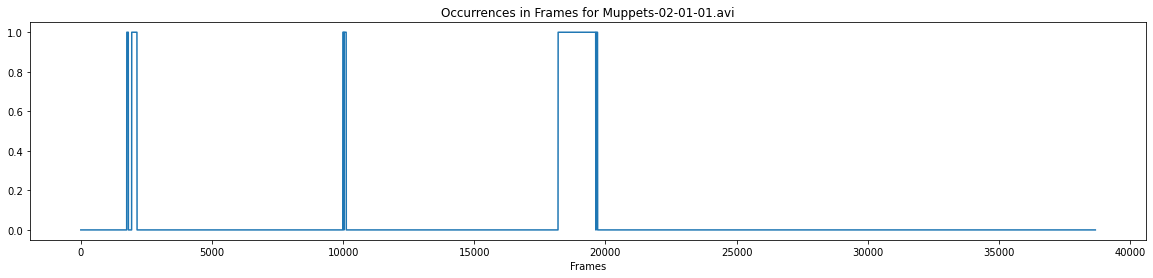

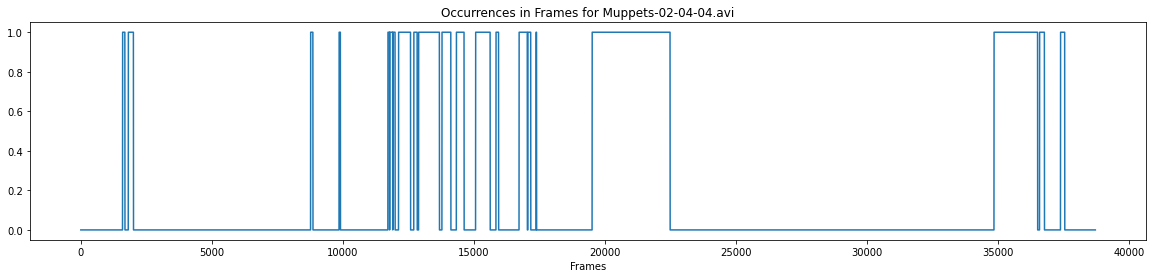

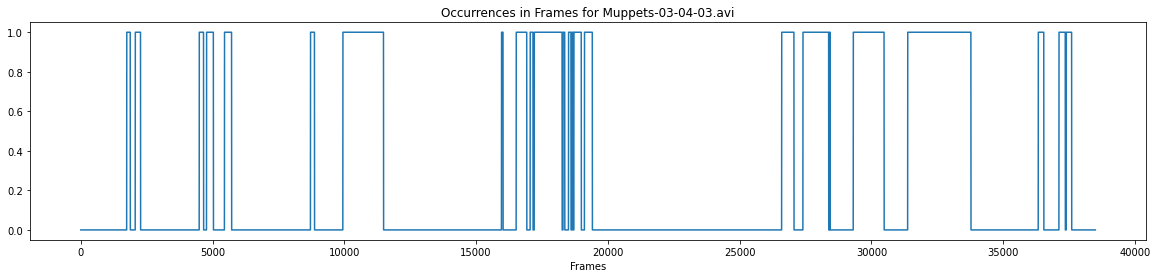

In [ ]:
for video in videos:
    plot = plt.figure(figsize=(20, 4))

    # define subplot
    subplot = plot.add_subplot(111)
    subplot.set_title(f"Occurrences in Frames for {video}")

    # define x axis
    subplot.set_xlabel('Frames')

    # mark occurrences
    frame_indicator = np.zeros(len(ground_truth[video]['Frame_number']))
    frame_indicator[ground_truth[video][ground_truth[video]["Pigs"] == 1].index] = 1

    subplot.plot(ground_truth[video]["Pigs"].index, frame_indicator)
    plt.show()

## 1.3 Load video data

### 1.3.1 Data structure to store splits
All frames are now split into a train, validation and test set.

In [12]:
train_data = dict()
valid_data = dict()
test_data = dict()

### 1.3.2 Create splits
The ground truth is split into training set, validation set and testing set.

In [13]:
for video in videos:
    train_data[video], test_data[video] = ms.train_test_split(ground_truth[video], test_size=0.2, shuffle=True, random_state=42)
    train_data[video], valid_data[video] = ms.train_test_split(train_data[video], test_size=0.25, random_state=42)

### 1.3.3 Get frames of video
The frames are written to the corresponding directory based on the splits and ground truth.

In [14]:
def retrieve_frames(video_file):
    # open a videoCap for this video
    video_cap = cv2.VideoCapture(os.path.join(VIDEO_PATH, video_file))

    # used to identify frame in ground truth
    frame_nr = 0

    # read all frames of video
    while True:
        # get one frame
        success_read, frame_read = video_cap.read()

        # no more frames available
        if not success_read:
            break

        # create filename
        filename = 'frame_%d.jpg' % frame_nr

        # write frames to dir
        if frame_nr in train_data[video_file].Frame_number:
            if (train_data[video_file][train_data[video_file].Frame_number == frame_nr].Pigs == 0).bool():
                cv2.imwrite(os.path.join(train_path_0, filename), frame_read)
            else:
                cv2.imwrite(os.path.join(train_path_1, filename), frame_read)

        elif frame_nr in valid_data[video_file].Frame_number:
            if (valid_data[video_file][valid_data[video_file].Frame_number == frame_nr].Pigs == 0).bool():
                cv2.imwrite(os.path.join(valid_path_0, filename), frame_read)
            else:
                cv2.imwrite(os.path.join(valid_path_1, filename), frame_read)

        elif frame_nr in test_data[video_file].Frame_number:
            if (test_data[video_file][test_data[video_file].Frame_number == frame_nr].Pigs == 0).bool():
                cv2.imwrite(os.path.join(test_path_0, filename), frame_read)
            else:
                cv2.imwrite(os.path.join(test_path_1, filename), frame_read)

        # go to next frame
        frame_nr += 1


for video in videos:
    retrieve_frames(video)
    print(f"Loaded frames of {video} successfully")

Loaded frames of Muppets-03-04-03.avi successfully
Loaded frames of Muppets-02-01-01.avi successfully
Loaded frames of Muppets-02-04-04.avi successfully


# 2 Model

## 2.1 Build model

### 2.1.1 Create the model
For our model we use a pretrained model and add additional layers for fine-tuning. We will not train the entire model, but only the layers added ourselves.

In [128]:
# create base model -> pretrained model
base_model = appl.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# add base model
head_model = base_model.output

# additional hidden layer
head_model = layers.Conv2D(512, kernel_size=(7, 7), activation="relu", padding='same')(head_model)
head_model = layers.Conv2D(512, kernel_size=(7, 7), activation="relu", padding='same')(head_model)
head_model = layers.Conv2D(512, kernel_size=(7, 7), activation="relu", padding='same')(head_model)

# create output layer
head_model = layers.MaxPooling2D(pool_size=(2, 2))(head_model)
head_model = layers.Flatten()(head_model)
head_model = layers.Dense(1, activation="sigmoid")(head_model)

# create model
model = models.Model(base_model.input, head_model)

# base model should not be trained
for layer in base_model.layers:
	layer.trainable = False

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### 2.1.2 Plot the model
Now we visualize the architecture of our model.

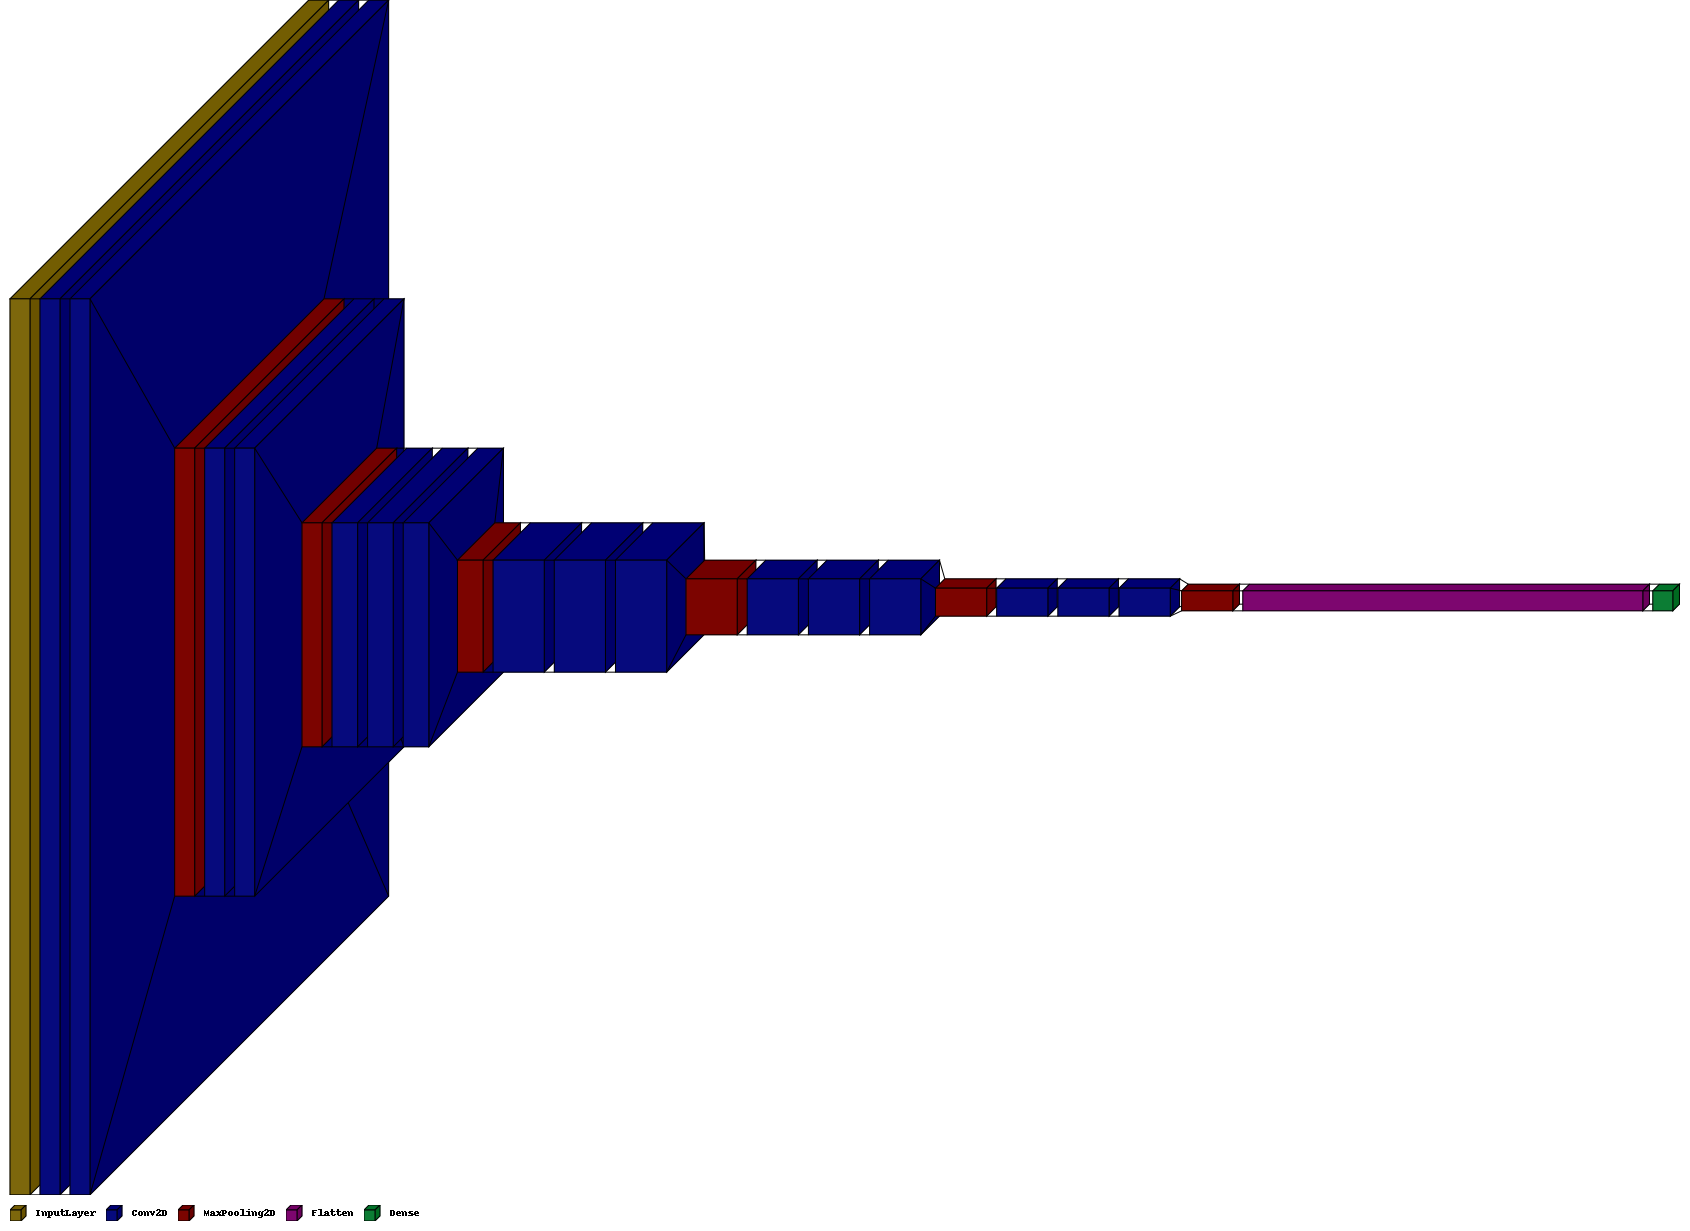

In [ ]:
# set colors for each used layer
color_map = collections.defaultdict(dict)
color_map[layers.InputLayer]['fill'] = '#7D670C'
color_map[layers.Conv2D]['fill'] = '#060A7D'
color_map[layers.MaxPooling2D]['fill'] = '#7C0400'
color_map[layers.Flatten]['fill'] = '#7D066F'
color_map[layers.Dense]['fill'] = '#0C7D34'
color_map[layers.Dropout]['fill'] = '#808080'

# plot the model
visualkeras.layered_view(model, legend=True, color_map=color_map)

## 2.2 Compile model
We compile the model with additional metrics and an optimizer.

In [129]:
metrics = [tf.keras.metrics.AUC(name='prc', curve='PR', num_thresholds=200),
                   tf.keras.metrics.Recall(name="recall"), 
                   tf.keras.metrics.Precision(name="precision")]

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(), 
              metrics=metrics)

## 2.3 Train model

### 2.3.1 Load training and validation sets
Now we can load the frames from the directories with inferred labels and the needed image size for our model.

In [17]:
# load training set
train_ds = utils.image_dataset_from_directory(
    directory=TRAINING_PATH,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224))

# load validation set
validation_ds = utils.image_dataset_from_directory(
    directory=VALIDATION_PATH,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224))

Found 44094 files belonging to 2 classes.
Found 19859 files belonging to 2 classes.


### 2.3.2 Analyze class imbalance
Since the underlying problem is an imbalanced classification problem, we will create class weights based on our training set.

In [ ]:
train_0 = len(os.listdir(train_path_0))
train_1 = len(os.listdir(train_path_1))

print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        train_1, 100 * float(train_1) / len(train_ds.file_paths)
    )
)

weight_for_0 = 1.0 / train_0
weight_for_1 = 1.0 / train_1

class_weight = {0: weight_for_0, 1: weight_for_1}

Number of positive samples in training data: 12051 (27.33% of total)


### 2.3.3 Normalize
We will also standardize our inputs by rescaling the frames.

In [18]:
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))

### 2.3.4 Train model
We use the validation loss for early stopping during the training process. Additionally, we create a model checkpoint observing the PRAUC, as a tradeoff between Precision and Recall.

In [ ]:
callbacks = [cb.EarlyStopping(monitor='val_loss', patience=10),
             cb.ModelCheckpoint(filepath=os.path.join(MODEL_PATH, 'video-dl'), monitor='val_prc', mode='max', save_best_only=True, save_weights_only=True)]

with tf.device('/device:GPU:0'):
  history = model.fit(train_ds, epochs=100, validation_data=validation_ds, callbacks=callbacks, class_weight=class_weight)

Epoch 1/100
1378/1378 [==============================] - 481s 334ms/step - loss: 5.1811e-06 - prc: 0.9776 - recall: 0.9554 - precision: 0.8989 - val_loss: 0.0579 - val_prc: 0.9896 - val_recall: 0.9806 - val_precision: 0.9329
Epoch 2/100
1378/1378 [==============================] - 455s 330ms/step - loss: 1.7229e-06 - prc: 0.9943 - recall: 0.9894 - precision: 0.9663 - val_loss: 0.0274 - val_prc: 0.9950 - val_recall: 0.9935 - val_precision: 0.9688
Epoch 3/100
1378/1378 [==============================] - 452s 328ms/step - loss: 1.0875e-06 - prc: 0.9962 - recall: 0.9935 - precision: 0.9775 - val_loss: 0.0966 - val_prc: 0.9770 - val_recall: 0.9979 - val_precision: 0.8865
Epoch 4/100
1378/1378 [==============================] - 453s 328ms/step - loss: 8.4112e-07 - prc: 0.9971 - recall: 0.9944 - precision: 0.9829 - val_loss: 0.0218 - val_prc: 0.9945 - val_recall: 0.9902 - val_precision: 0.9826
Epoch 5/100
1378/1378 [==============================] - 456s 330ms/step - loss: 6.6319e-07 - prc: 0

### 2.3.5 Plot training results

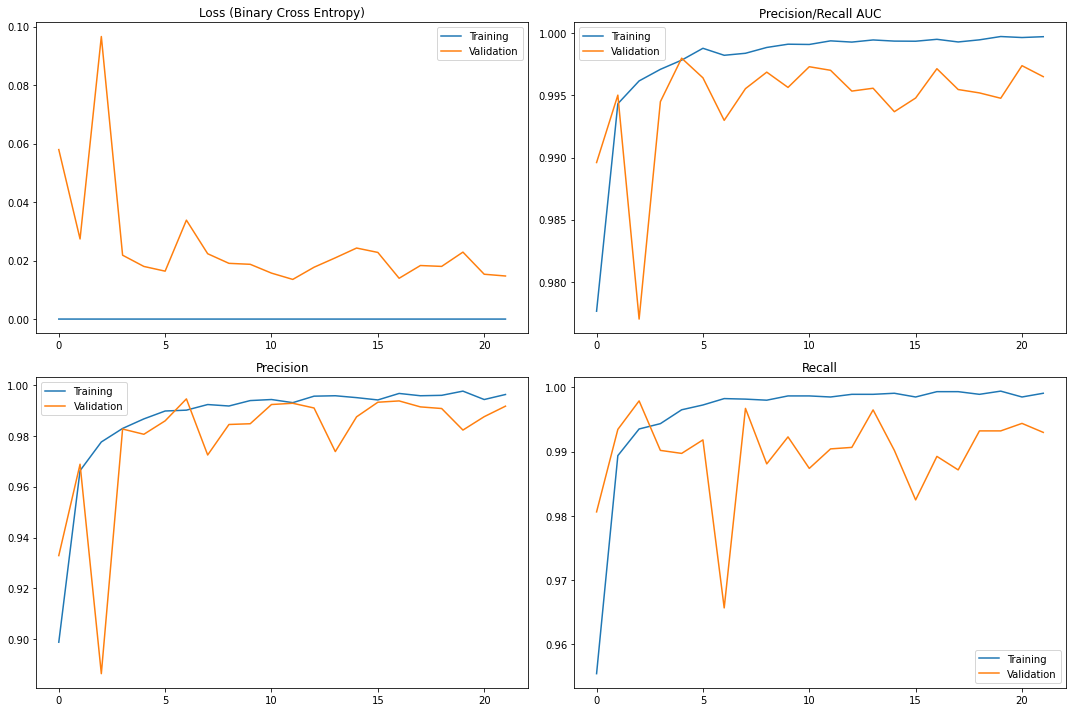

In [ ]:
history = history.history
epochs = np.arange(len(history["loss"]))

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(epochs, history["loss"], label="Training")
axs[0, 0].plot(epochs, history["val_loss"], label="Validation")
axs[0, 0].set_title("Loss (Binary Cross Entropy)")
axs[0, 0].legend()

axs[0, 1].plot(epochs, history["prc"], label="Training")
axs[0, 1].plot(epochs, history["val_prc"], label="Validation")
axs[0, 1].set_title("Precision/Recall AUC")
axs[0, 1].legend()

axs[1, 0].plot(epochs, history["precision"], label="Training")
axs[1, 0].plot(epochs, history["val_precision"], label="Validation")
axs[1, 0].set_title("Precision")
axs[1, 0].legend()

axs[1, 1].plot(epochs, history["recall"], label="Training")
axs[1, 1].plot(epochs, history["val_recall"], label="Validation")
axs[1, 1].set_title("Recall")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

As we can see in the results, after unstable first 5 epochs all four metrics become better almost every epoch. In general the scores are very satisfactory. Since we added a Checkpoint during our training process, we get a model where Precision and Recall are balanced with a high score.

# 3 Results

## 3.1 Load best model

In [131]:
model.load_weights(os.path.join(MODEL_PATH, "video-dl"))

## 3.2 Evaluate model
Now we evaluate our best model on the test set.

In [132]:
# load testing set
test_ds = utils.image_dataset_from_directory(
    directory=TESTING_PATH,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224))

# normalize testing set
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# evaluate the model
results = model.evaluate(test_ds, batch_size=128)

Found 16275 files belonging to 2 classes.
509/509 [==============================] - 96s 186ms/step - loss: 0.0204 - prc: 0.9967 - recall: 0.9910 - precision: 0.9875


## 3.3 Predict
For the final evaluation we make a prediction for every frame of the 3 sets.

In [139]:
y_hat_train = []
y_train = []
y_hat_valid = []
y_valid = []
y_hat_test = []
y_test = []

for X, y in train_ds:
  y_hat_train = np.concatenate([y_hat_train, model.predict(X, verbose = 0).reshape(-1)])
  y_train = np.concatenate([y_train, y.numpy().reshape(-1)])

for X, y in validation_ds:
  y_hat_valid = np.concatenate([y_hat_valid, model.predict(X, verbose = 0).reshape(-1)])
  y_valid = np.concatenate([y_valid, y.numpy().reshape(-1)])

for X, y in test_ds:
  y_hat_test = np.concatenate([y_hat_test, model.predict(X, verbose = 0).reshape(-1)])
  y_test = np.concatenate([y_test, y.numpy().reshape(-1)])

## 3.4 Calculate PR curve for validation set and find optimal cutoff value
We use the labels of ground truth together with our prediction to calculate a Precision-Recall curve for estimating the optimal cutoff threshold.

In [140]:
precision, recall, thresholds = mt.precision_recall_curve(y_valid, y_hat_valid)

fscore = (2 * precision * recall) / (precision + recall)

optimal_idx = np.argmax(fscore)
optimal_cutoff = thresholds[optimal_idx]

print(f"Found optimal cutoff threshold at {optimal_cutoff}")

Found optimal cutoff threshold at 0.6116859316825867


## 3.5 Show ROC curves
Now we create Roc curves for every set.

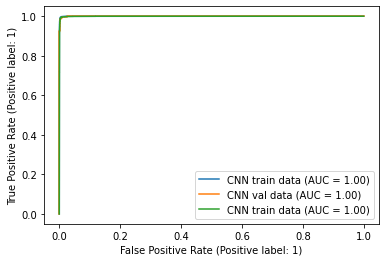

In [141]:
fig, ax = plt.subplots()

mt.RocCurveDisplay.from_predictions(y_train, y_hat_train, name="CNN train data", ax=ax)
mt.RocCurveDisplay.from_predictions(y_valid, y_hat_valid, name="CNN val data", ax=ax)
mt.RocCurveDisplay.from_predictions(y_test, y_hat_test, name="CNN train data", ax=ax)

plt.show()

As we can see, the ROC curves are almost perfect.

## 3.6 Discretize predictions to calculate further metrics

In [142]:
# discretize predictions
cutoff = optimal_cutoff

y_hat_train_discrete = y_hat_train.copy()
y_hat_train_discrete[y_hat_train_discrete < cutoff] = 0
y_hat_train_discrete[y_hat_train_discrete >= cutoff] = 1

y_hat_val_discrete = y_hat_valid.copy()
y_hat_val_discrete[y_hat_val_discrete < cutoff] = 0
y_hat_val_discrete[y_hat_val_discrete >= cutoff] = 1

y_hat_test_discrete = y_hat_test.copy()
y_hat_test_discrete[y_hat_test_discrete < cutoff] = 0
y_hat_test_discrete[y_hat_test_discrete >= cutoff] = 1

## 3.7 Calculate metrics
Now we will calculate some further metrics (Precision, recall, fscore, AP) for our three set, which will be visualized afterwards.

In [143]:
# precision, recall, fscore
prf = {}
prf["train"] = mt.precision_recall_fscore_support(y_train, y_hat_train_discrete, average="binary")
prf["val"] = mt.precision_recall_fscore_support(y_valid, y_hat_val_discrete, average="binary")
prf["test"] = mt.precision_recall_fscore_support(y_test, y_hat_test_discrete, average="binary")

# average precision
ap = {}
ap["train"] = mt.average_precision_score(y_train, y_hat_train_discrete)
ap["val"] = mt.average_precision_score(y_valid, y_hat_val_discrete)
ap["test"] = mt.average_precision_score(y_test, y_hat_test_discrete)

## 3.8 Visualize Results

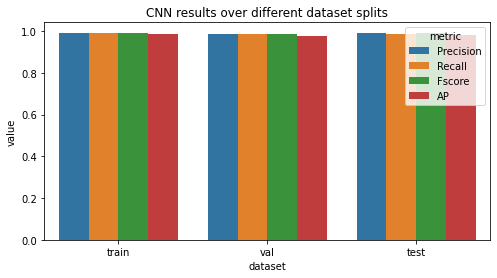

In [145]:
# make dataframe
res_holder = []
for ds in ["train", "val", "test"]:
    precision = {"dataset": ds, "metric": "Precision", "value": prf[ds][0]}
    recall = {"dataset": ds, "metric": "Recall", "value": prf[ds][1]}
    fscore = {"dataset": ds, "metric": "Fscore", "value": prf[ds][2]}
    avg_precision = {"dataset": ds, "metric": "AP", "value": ap[ds]}
    res_holder.append(precision)
    res_holder.append(recall)
    res_holder.append(fscore)
    res_holder.append(avg_precision)

res_df = pd.DataFrame(res_holder)

# plot
_, ax = plt.subplots(figsize=(8, 4))
g = sns.barplot(data=res_df, x="dataset", y="value", hue="metric", ax=ax).set(
    title="CNN results over different dataset splits"
)

plt.show()